# System analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

### 1) Load data from BIN files

In [2]:
### Load data from disk
import pickle
with open('aida_agdistis.bin', 'rb') as outfile:
    aida_agd_articles=pickle.load(outfile)
with open('wes2015_agdistis.bin', 'rb') as outfile:
    wes_agd_articles=pickle.load(outfile)
with open('aida_spotlight.bin', 'rb') as outfile:
    aida_spot_articles=pickle.load(outfile)
with open('wes2015_spotlight.bin', 'rb') as outfile:
    wes_spot_articles=pickle.load(outfile)
    
wes_title='wes2015'
aida_title='aida'

In [3]:
import utils
import plot_utils
import time
from collections import defaultdict

**1.1. Pick dataset**

In [4]:
print(type(aida_agd_articles))
spot_articles=aida_spot_articles.union(wes_spot_articles)
agd_articles=aida_agd_articles.union(wes_agd_articles)
#print(len(articles))
skip_nils=True

<class 'set'>


### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [5]:
print("AGDISTIS")
agd_acc=plot_utils.overall_performance(agd_articles, skip_nils)
print(agd_acc)
print()
print("SPOTLIGHT")
spot_acc=plot_utils.overall_performance(spot_articles, skip_nils)
print(spot_acc)

AGDISTIS
26695 56404
0.4732820367349833

SPOTLIGHT
38180 56404
0.6769023473512517


#### 2.2. Prepare forms subset to evaluate ambiguous forms

In [6]:
def compute_acc_on_selection(arts, forms_set):
    correct=0
    total=0
    for article in arts:
        for entity in article.entity_mentions:
            if entity.mention in forms_set:
                total+=1
                if entity.gold_link==entity.sys_link:
                    correct+=1
    print(correct, total)
    return correct/total

#### 2.3. Only forms that are interpretted as NILs and not-NILs

In [7]:
interpretations, references = plot_utils.get_interpretations_and_references(spot_articles, skip_nils=False)
ambiguity={}
for form,meanings in interpretations.items():
    ambiguity[form]=len(meanings)

In [8]:
nil_nonnil_forms=set()
for form, amb in ambiguity.items():
    if amb>1:
        if '--NME--' in interpretations[form]:
            nil_nonnil_forms.add(form)

In [9]:
nn_f_acc=compute_acc_on_selection(spot_articles, nil_nonnil_forms)
nn_f_acc

1413 3061


0.4616138516824567

#### 2.4. Only ambiguous forms

In [10]:
interpretations, references = plot_utils.get_interpretations_and_references(spot_articles, skip_nils=True)
ambiguity={}
for form,meanings in interpretations.items():
    ambiguity[form]=len(meanings)

In [11]:
ambiguous_forms=set()
for form, amb in ambiguity.items():
    if amb>1:
        ambiguous_forms.add(form)

In [12]:
amb_f_acc=compute_acc_on_selection(spot_articles, ambiguous_forms)
amb_f_acc

8660 14804


0.584977033234261

### 3) Correlation between FORM frequency and accuracy

# Note: All stats from here on are on both datasets jointly, with Spotlight

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

<span style="background-color:yellow">TODO: REFACTOR</span>

**3.1. Correct and total amount per form**

In [16]:
articles=agd_articles

In [17]:
correct_by_form = defaultdict(int)
total_by_form = defaultdict(int)
for article in articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            if entity.sys_link==entity.gold_link:
                correct_by_form[entity.mention]+=1
            total_by_form[entity.mention]+=1

**3.2. Aggregate per frequency**

In [18]:
from collections import OrderedDict
agg_per_frequency=OrderedDict()
forms_by_count=defaultdict(set)
for form, count in total_by_form.items():
    str_count=str(count)
    if count not in agg_per_frequency:
        agg_per_frequency[count]={'c':0, 't':0}
    agg_per_frequency[count]['c']+=correct_by_form[form]
    agg_per_frequency[count]['t']+=count
    forms_by_count[count].add(form)
print(agg_per_frequency)

OrderedDict([(109, {'c': 162, 't': 218}), (7, {'c': 790, 't': 1876}), (56, {'c': 26, 't': 56}), (15, {'c': 211, 't': 720}), (80, {'c': 43, 't': 80}), (4, {'c': 1495, 't': 3044}), (8, {'c': 576, 't': 1560}), (13, {'c': 269, 't': 988}), (5, {'c': 1160, 't': 2490}), (2, {'c': 3240, 't': 5912}), (10, {'c': 592, 't': 1480}), (1, {'c': 6639, 't': 11830}), (14, {'c': 287, 't': 854}), (3, {'c': 2126, 't': 3957}), (9, {'c': 562, 't': 1548}), (21, {'c': 142, 't': 336}), (22, {'c': 147, 't': 418}), (28, {'c': 28, 't': 252}), (6, {'c': 1097, 't': 2070}), (23, {'c': 131, 't': 322}), (147, {'c': 147, 't': 294}), (11, {'c': 379, 't': 1012}), (63, {'c': 122, 't': 252}), (351, {'c': 315, 't': 351}), (210, {'c': 303, 't': 420}), (26, {'c': 135, 't': 442}), (18, {'c': 193, 't': 576}), (33, {'c': 22, 't': 165}), (19, {'c': 209, 't': 456}), (45, {'c': 38, 't': 90}), (90, {'c': 34, 't': 90}), (29, {'c': 66, 't': 174}), (55, {'c': 42, 't': 55}), (27, {'c': 103, 't': 378}), (98, {'c': 92, 't': 196}), (69, {'c

In [19]:
accs=OrderedDict()
for key in sorted(agg_per_frequency, reverse=True):
    acc=agg_per_frequency[key]['c']*100.0/agg_per_frequency[key]['t']
    print(key, acc, forms_by_count[key])
    accs[key]=acc

464 0.0 {'U.S.'}
351 89.74358974358974 {'Germany'}
274 67.51824817518248 {'France'}
237 58.22784810126582 {'England'}
210 72.14285714285714 {'Australia', 'German'}
195 94.35897435897436 {'Italy'}
185 95.67567567567568 {'Spain'}
184 2.717391304347826 {'Britain'}
180 85.0 {'Russia'}
157 73.2484076433121 {'London'}
156 70.51282051282051 {'China'}
147 50.0 {'French', 'LONDON'}
143 8.391608391608392 {'NEW YORK'}
139 66.18705035971223 {'Japan'}
132 95.45454545454545 {'United States'}
129 67.44186046511628 {'Russian'}
116 82.32758620689656 {'mathematics', 'Sweden'}
113 0.0 {'British'}
109 74.31192660550458 {'Reuters', 'Israel'}
103 30.097087378640776 {'Pakistan'}
102 59.80392156862745 {'American', 'Paris'}
101 0.0 {'English'}
98 46.93877551020408 {'Iraq', 'Belgium'}
96 8.333333333333334 {'Europe'}
95 58.94736842105263 {'Berlin'}
93 93.54838709677419 {'Clinton'}
90 37.77777777777778 {'India'}
85 30.58823529411765 {'Netherlands', 'CHICAGO'}
84 77.38095238095238 {'Austria'}
81 87.65432098765432 

**3.3. Plot frequency distribution**

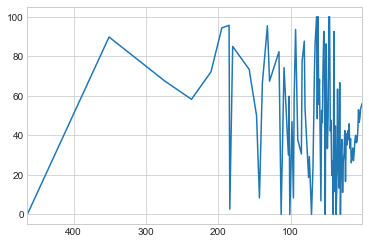

In [20]:
import matplotlib.pyplot as plt
plt.xlim(list(accs.keys())[0],list(accs.keys())[-1])
plt.plot(list(accs.keys()), list(accs.values()))
plt.show()

### 4) Entropy

In [39]:
from scipy.stats import entropy
form_entropies={}
for form in ambiguous_forms:
    counts=plot_utils.get_form_counts(spot_articles, form)
    counts=list(counts)
    form_entropies[form]=entropy(counts,base=len(counts))
form_entropies

{'Munich': 0.39124356362925561,
 'Essex': 0.26676498780302604,
 'on the line': 1.0,
 'NEW YORK': 0.68012391203024902,
 'Northern Ireland': 0.9709505944546688,
 'Singer': 0.50325833477564574,
 'Francis': 0.91829583405448945,
 'Soviet': 0.27619542764793908,
 'Commonwealth': 0.37123232664087569,
 'Dirichlet': 0.59167277858232736,
 'Simon': 1.0,
 'achievements': 0.99999999999999978,
 'Bulgarian': 0.59167277858232736,
 'Navy': 1.0,
 'Baily': 0.5435644431995964,
 'connections': 1.0,
 'Danish': 0.85279248849004041,
 'stars': 0.46899559358928117,
 'Brazilian': 0.21084230031853216,
 'system': 0.43949698692151334,
 'Liechenstein': 1.0,
 'men': 1.0,
 'systems': 0.81127812445913283,
 'interpretation': 0.91829583405448945,
 'assistant': 0.94639463035718596,
 'Natural Philosophy': 0.91829583405448945,
 'return': 1.0,
 'Gold Coast': 0.81127812445913283,
 'descriptions': 0.81127812445913283,
 'emotions': 0.91829583405448945,
 'SAN MARINO': 0.91829583405448945,
 'Wales': 0.74803295577192641,
 'Science'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


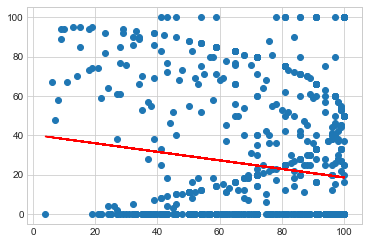

In [40]:
import numpy as np

x_form=[]
y_form=[]
for f in ambiguous_forms:
    y_form.append(int(correct_by_form[f]*100/total_by_form[f]))
    x_form.append(int(form_entropies[f]*100))

x_form=np.array(x_form)
y_form=np.array(y_form)

fig, ax = plt.subplots()
fit = np.polyfit(x_form, y_form, deg=1)
ax.plot(x_form, fit[0] * x_form + fit[1], color='red')
ax.scatter(x_form, y_form)

fig.show()

#plt.plot(x_form, y_form, 'o')

In [42]:
# Scipy offers many statistical functions, among which the Pearson and Spearman correlation measures.
from scipy.stats import pearsonr, spearmanr

correlation, significance = spearmanr(x_form,y_form)
print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

The Spearman correlation between X and Y is: -0.158225175037 . Significance:  2.69492159654e-07


### 4) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

<span style="background-color:yellow">TODO: REFACTOR</span>

**4.1. Correct and total amount per URI**

In [ ]:
correct_by_uri = defaultdict(int)
total_by_uri = defaultdict(int)
pageranks = defaultdict(set)
uri_pageranks={}
for article in articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            if entity.sys_link==entity.gold_link:
                correct_by_uri[entity.gold_link]+=1
            total_by_uri[entity.gold_link]+=1
            pagerank=int(entity.gold_pr)
            pageranks[pagerank].add(entity.gold_link)
            uri_pageranks[entity.gold_link]=entity.gold_pr

**4.2. Aggregate per frequency**

In [ ]:
from collections import OrderedDict
agg_per_frequency=OrderedDict()
uris_by_count=defaultdict(set)
for uri, count in total_by_uri.items():
    str_count=str(count)
    if count not in agg_per_frequency:
        agg_per_frequency[count]={'c':0, 't':0}
    agg_per_frequency[count]['c']+=correct_by_uri[uri]
    agg_per_frequency[count]['t']+=count
    uris_by_count[count].add(uri)
print(agg_per_frequency)

In [ ]:
accs=OrderedDict()
for key in sorted(agg_per_frequency, reverse=True):
    acc=agg_per_frequency[key]['c']*100.0/agg_per_frequency[key]['t']
    print(key, acc, uris_by_count[key])
    accs[key]=acc

In [ ]:
print(agg_per_frequency)

**4.3. Plot accuracies**

In [ ]:
import matplotlib.pyplot as plt
plt.xlim(list(accs.keys())[0],list(accs.keys())[-1])
plt.plot(list(accs.keys()), list(accs.values()))
plt.show()

#### 4.4. Plot PageRank vs accuracy

In [ ]:
skip_zeros=True

In [ ]:
pg_accs={}
for pr in sorted(pageranks.keys()):
    if skip_zeros and pr==0: continue
    c=0
    t=0
    uris=pageranks[pr]
    for uri_with_pr in uris:
        c+=correct_by_uri[uri_with_pr]
        t+=total_by_uri[uri_with_pr]
    acc=c/t
    pg_accs[pr]=acc

In [ ]:
pg_accs

In [ ]:
plot_utils.plot_freq_noagg(pg_accs)

### 5) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**5.1. Collect interpretations for a form**


In [ ]:
interpretations=defaultdict(set)
for article in articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [ ]:
interpretations['Marseille']

**5.2. Aggregate per rank**

In [ ]:
ambiguity={}
for form,meanings in interpretations.items():
    ambiguity[form]=len(meanings)
ambiguity

In [ ]:
correct_per_form=defaultdict(dict)
total_per_form=defaultdict(dict)
for article in articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if skip_nils and meaning=='--NME--':
            continue
        if ambiguity[form]==1:
            continue
        if meaning not in total_per_form[form]:
            total_per_form[form][meaning]=0
            correct_per_form[form][meaning]=0
        total_per_form[form][meaning]+=1
        if meaning==mention.sys_link:
            correct_per_form[form][meaning]+=1

In [ ]:
len(total_per_form)

In [ ]:
correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, total_per_form)
print(correct_per_rank)
print(total_per_rank)

In [ ]:
plot_utils.plot_ranks(correct_per_rank, total_per_rank)

### 6) Ranks of the top-N most frequent forms

<span style="background-color:lightgreen">Section 6.5. of the paper</span>


In [ ]:
# Top 10 have form frequency of >135

min_frequency=135
correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, total_per_form, min_frequency=min_frequency)
print(correct_per_rank)
print(total_per_rank)

In [ ]:
plot_utils.plot_ranks(correct_per_rank, total_per_rank)

#### The reason for the peak in form 3 is NEW YORK, where the state is third most common in the corpus

In [ ]:
form='NEW YORK'
print(total_per_form[form])
print(correct_per_form[form])

In [ ]:
form='Germany'
print(total_per_form[form])
print(correct_per_form[form])

#### What is going on with China?

In [ ]:
for a in articles:
    for m in a.entity_mentions:
        if m.mention=='China':
            print(m.gold_link, m.sys_link)

### 7) PageRank analysis

<span style="background-color:lightgreen">Section 6.6. of the paper</span>

In [ ]:
uri_pageranks

In [ ]:
correct_per_rank_pr=defaultdict(int)
total_per_rank_pr=defaultdict(int)
for form, data in total_per_form.items():
    form_pageranks=[]
    for uri in data.keys():
        form_pageranks.append(tuple((uri_pageranks[uri], uri)))
#        print(correct_by_uri[uri], total_by_uri[uri], uri, uri_pageranks[uri])
#    print(sorted(form_pageranks, reverse=True))
    for rank in range(1,len(form_pageranks)+1):
#        print(rank, form_pageranks[rank-1])
        correct_per_rank_pr[rank]+=correct_by_uri[form_pageranks[rank-1][1]]
        total_per_rank_pr[rank]+=total_by_uri[form_pageranks[rank-1][1]]
#    print(form,data)
#    input('continue')

In [ ]:
print(correct_per_rank_pr)
print(total_per_rank_pr)

In [ ]:
plot_utils.plot_ranks(correct_per_rank_pr, total_per_rank_pr)

### 8) Notes

* connectivity should reflect popularity -> try pageRank
* this is the hardest part of the EL task
* sometimes nils are most frequent
* NILs - maybe set them aside
* very basic baseline - throw away dbpedia, randomly assign from the training data - build this baseline
* always try the most frequent one
* popular, transparent, and the best one - distinguish between open source systems
* look at coreference too (noun phrases and pronouns)
* annotation or not of coreferential expressions (we can also just use them in a solution)? 

**5.3. Aggregate per rank**



#### Summary of the todos:
* Another system or 2 (spotlight) - PIEK: take popular, transparent, and the best one
* More datasets
* NIL entities
* Baseline
* Coreference